#**Rating prediction based on review text for imbalanced dataset**

In this project I had a target to make the prediction of user rating based on the review text, and see how the result can be explained with using different models. I have taken the most explainable models (Decesion Tree, and Logistic regression with L1 penalty which allows variable selection and so feature number reduction).  

  For the analysis, I'm going to take a dataset of reviews from Amazon in the directory "Amazon fashion", taken from the following resource: https://nijianmo.github.io/amazon/index.html. This dataset represents the 3176 reviews of the Amazon users in the category "AMAZON FASHION" for the years from December 2009 to July 2018. The length of each review is from 1 to 1083 words. This is a  reduced dataset, which contains only the products with at least 5 reviews in each.

  For the models evaluation, I'm using F1 measure, as the dataset is imbalanced, and this measure one of the best represent the performance for such type of a dataset, as accuracy will not be helpful, it can be close to the frequency of prediction of dominating class. 

To start, let's load all the needed libraries:

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import sklearn
import nltk
from nltk import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import string
import gzip
import json
from collections import Counter

Then, let's load the dataset itself, and take from it only 2 columns: `overall`, which will represent the ratings, and `reviewText`, which will represent the texts of reviews.   

I'm going to drop any missing values, as there are only small number of them, and convert the `reviewText` field to `string` format. 

In [140]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

file_path = 'AMAZON_FASHION_5.json.gz'
i = 0
data = {}
for d in parse(file_path):
  data[i] = d
  i += 1
review = pd.DataFrame.from_dict(data, orient='index')

reviews = pd.DataFrame({"reviewText" : review.reviewText, 'overall': review.overall})

reviews.reviewText.astype('string')
reviews=reviews.dropna()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 0 to 3175
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  3160 non-null   object 
 1   overall     3160 non-null   float64
dtypes: float64(1), object(1)
memory usage: 74.1+ KB


I'm going to split the dataset on the training and test datasets and separate features from the labels

In [142]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(reviews, test_size=0.2, random_state=111)
train_x = train.reviewText
train_y = train.overall
test_x = test.reviewText
test_y = test.overall

If we will check, what is the split per 5 ratings, we will see that the most rates are falling down in the '5.0' category, so it is obvious that the dataset is highly imbalanced. We will solve it further. 

Counter({5.0: 1725, 4.0: 371, 3.0: 263, 1.0: 91, 2.0: 78})


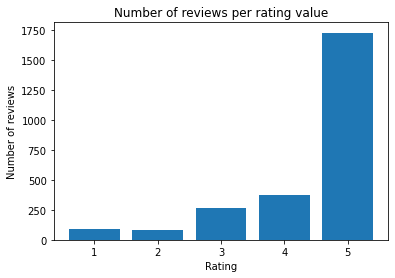

In [13]:
class_count = Counter(train_y)
print(class_count)
rating = class_count.keys()
observations = class_count.values()

plt.bar(rating, observations)
plt.title('Number of reviews per rating value')
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.show()

Before feeding data to the model, I'm going to do the following steps for data processing:

1. Delete all hyperlinks using the library `BeautifulSoup`, as we have multiple links in the text on the images and on the other pages, which will prevent the correct classification.
2. Convert all the words in the lower case and remove punctuation signs 
3. Remove the custom list of stop words, including the pronouns in different forms and articles. I have found during the other investigation, that there is a loss is prediction accuracy in case if we are using for this specific task `nltk` or some other type of stop word corpus, so created my own list of words. This list can be enhanced further as during some experiments I have found that deletion of some other partial categories of words can boost the F1 measure on couple of %. So far I'm deleting pronouns in different forms, and also articles.
4. Make stemming for all the words: the words are reduced to its basic form, to its most meaningful part. I use NLTK library to do the stemming.
5. Vectorize it with `CountVectorizer`. 

In [5]:
import re

stop_words = ["i", "me", "my", "myself", "mine",
               "we", "us", "our", "ours", "ourselves",
               "you", "your", "yours", "yourself",
               "they", "their", "themselves", 
               "he", "his", "himself",
               "she", "her", "herself",
               "a", "an", "the", 
               "it", "its"]

In order to be able to tokenize both test and train data with one line, I will make helper function to join all tokenization steps. 

In [144]:
from bs4 import BeautifulSoup

def custom_tokenizer(df_text):
    word_tokens=[]
    
    #Transform train dataset
    for review in df_text:
        
        #Removing HTML tags from reviews
        review_clean = BeautifulSoup(review).get_text()

        #Removing all punctuation signs from the text, replacing it with spaces and transforming all to lower case
        review_clean = re.sub("[^a-zA-Z0-9']"," ",review_clean).lower()
        
        #Splitting review into words, removing stopwords and
        words_clean=review_clean.split()

        #Remove stop words
        words_clean = [w for w in words_clean if not w in stop_words]

        #stemming
        ps = PorterStemmer()
        words_clean = [ps.stem(w) for w in words_clean]
        
        #Join all the words in the review to a single string
        words_string=(str(" ".join(words_clean)))

        #Append it to array of reviews
        word_tokens.append(words_string)

    return word_tokens

In the next line, I'm creating vectorizer, which will learn the vocabulary from the text and which we will further use to vectorize not only the training but also the test set. Vectorization is done for 1 to 4-grams, as in some cases taking n-grams is more efficient for text classification. 

In [145]:
count_vect=CountVectorizer(analyzer="word", ngram_range=(1,4),max_df = 0.5,min_df = 0.001)

train_tokenized=custom_tokenizer(train_x)

Below, you can see the vocabulary, generated by the vectorizer, which represent the ngrams with its index in the vocabulary.

In [175]:
#Vectorize all the array of reviews and vectorize using vocabulary of training data
train_vect=count_vect.fit_transform(train_tokenized)
vocabulary=count_vect.vocabulary_


Then, we will transform the count matrix to the term-frequency matrix with TFIDF transformer. This will allow to reduce the impact of basic frequently seen words on the rating evaluation.

In [148]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_train_x = tfidf_transformer.fit_transform(train_vect)

Now, to deal with the imbalance in the categories, I will use the library `imblearn` and method `RandomUnderSampler`, which basically randomly selects the equal number of observation in each class in the training dataset, which basically will be same as the smallest number of observations over classes. 

In [150]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=0, replacement=True)

In [151]:
train_x_resampled, train_y_resampled = undersampler.fit_resample(tfidf_train_x, train_y)


In [153]:
class_count_resampled = Counter(train_y_resampled)
print(class_count_resampled)


Counter({1.0: 78, 2.0: 78, 3.0: 78, 4.0: 78, 5.0: 78})


As you can see, now the balance is achieved. 

To continue, we will do the tokenization of the test dataset, but we will vectorize it with different vectorizer, which will not take the vocabulary from the test dataset, but use the one, built on the training dataset. Also, for the test dataset, we will not need to deal with imbalance, as all we will need is to make the evaluation, so the imbalance will not affect the classifier performance.

In [154]:
test_tokenized=custom_tokenizer(test_x)
count_vect_test=CountVectorizer(analyzer="word", vocabulary=vocabulary)

#Vectorize all the array of reviews and vectorize using vocabulary of training data
test_vect=count_vect_test.fit_transform(test_tokenized)
#TFIDF transformation
tfidf_test_x = tfidf_transformer.fit_transform(test_vect)

Next, we are going to build 2 models: DecesionTree, and LogisticRegression with L1 regularization. The reason why I have chosen it was to show, how to explain the decesion process of the classifier and those are the 2 best models for that.

The Decesion tree model will split the data on each step and evaluate the class. Based on the impurity measure value, it will decide whether to take another feature for the next split or stop in this point. Further I'm going to display all the features, which were used for making decesion for my dataset.

The Logistic regression with L1 regularization is basically lasso model, which can make variable selection. For the chosen value of hyperparameter `lambda` it will remove some number of predictors which deem to be non-valuable. So, for the text classification, we will have at the end the distinct list of ngrams, which better characterize each class. 

In [155]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

model.fit(tfidf_train_x, train_y)
predicted=model.predict(tfidf_test_x)


In [156]:
tree_words=model.tree_.feature.tolist()

In [157]:
words_t=[]

for i in tree_words:
  for word, index in vocabulary.items():  
    if index==i:
        words_t.append(word)

print(words_t)
len(words_t)

['but', 'love', 'return', 'think', 'larg', 'not', 'get', 'bit', 'big', 'off', 'wife', 'exercis', 'spot', 'out', 'light weight', 'pant', 'nice', 'shoe is', 'toe', 'thi style', 'wrong', 'doesn hurt', 'cross fit and', 'would buy', 'like', 'artculo equivocado en', 'squeaki', 'look veri cheap', 'intend purpos', 'as describ', 'valu', 'veri comfort', 'do requir constant', 'ha stolen', 'second', 'lightweight', 'roll down', 'for', 'fit', 'circuit', 'deliv', 'nice', 'qualiti', 'veri nice', 'nice shoe', 'no pocket', 'shoe', 'weight', 'of', 'slip', 'are', 'waaaay', 'store and', 'to', 'have so far', 'wear', 'size', 'not', 'of', 'much', 'what like most', 'expect', 'not', 'wear', 'shoe wa somewhat', 'nike', 'pair', 'these', 'had', 'for', 'and wa tad too', 'smaller for nike', 'becaus order', 'shoe love them', 'these', 'them', 'size', 'of', 'row now initi', 'pant but', 'of shoe too', 'switch to fruit of', 'both', 'as', 'of', 'day', 'than', 'too', 'will', 'descript but these are', 'wide feet', 'that be'

92

We can see that the split starts with the word `but`, and goes up to the ngram `that be`. We can observe on the next plot, how the decesion tree look like:

In [158]:
from sklearn import tree
from matplotlib import pyplot as plt
classes=['1.0','2.0','3.0', '4.0', '5.0']
tree_plot = plt.figure(figsize=(150,150))
_ = tree.plot_tree(model,feature_names=names,  
                   class_names=classes, filled=True)
tree_plot.savefig("decistion_tree.png")


If we will look at the tree, we will see that the split is very skewed, and on big number of levels we can see the splits not only between close categories, like "5.0" and "4.0", but there are several splits, where the decesion is being made between "5.0" and "1.0", which are basically the opposite categories. This can give the idea that big emotions which can happen in absolute opposite reviews can be correctly classified by one word or ngram, which will represent the tone of those emotions. Expectedly for example, one of the separators between "1.0" and "5.0" is the word "return" and the word "wrong". 

In [159]:
predicted = predicted.reshape(predicted.shape[0],)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
f1 = f1_score(test_y, predicted, average="micro")
proba_score=model.predict_proba(tfidf_test_x)
proba_score=proba_score[:, 1]

print( f1)

0.7294303797468354


F1 measure for Decesion tree classifier is just 0.729, which is pretty good for a simple classifier, but definitely can be improved in case of using more advanced classifier. Apart from F1, let's see the confusion matrix for this dataset. In order to reduce the impact of dataset imbalance, we will normalize the matrix. 

None


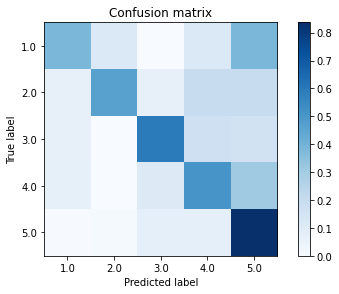

In [160]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confusionmatrix=confusion_matrix(test_y, predicted)
normalized_matrix=confusionmatrix.astype("float")/confusionmatrix.sum(axis=1)[:, np.newaxis]
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, [1.0, 2.0, 3.0, 4.0, 5.0])
    plt.yticks(tick_marks, [1.0, 2.0, 3.0, 4.0, 5.0])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(plot_confusion_matrix(normalized_matrix))

From the confusion matrix we can see, that the least misclassified class is '5.0'. The mose misclassified class is "1.0", and we can wee that it is constantly mixed up in the classification with "5.0" while other classes are not that often misclassified that way. Again, this can happen that the strength of emotions in the "5.0" and "1.0" classes are somewhat similar, and the decesion ngrams used in current models do not allow to make the classification correctly. 

We can also see that all classes tend to be more often misclassified by higher class, than lower one. 


In [161]:
from sklearn.linear_model import LogisticRegression
lmodel = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l1')
lmodel.fit(tfidf_train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

0.759493670886076
None


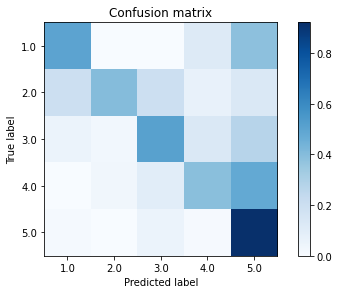

In [162]:
predicted_logistic=lmodel.predict(tfidf_test_x)
f1 = f1_score(test_y, predicted_logistic, average="micro")
print( f1)
confusionmatrix1=confusion_matrix(test_y, predicted_logistic)
normalized_matrix1=confusionmatrix1.astype("float")/confusionmatrix1.sum(axis=1)[:, np.newaxis]
print(plot_confusion_matrix(normalized_matrix1))

For Logistic regression, we can see that the F1 measure is much higher, at the level of 0.759, and the confusion matrix is different. Now the most misclassified class is "4.0", while class "1.0" classified correctly much more often. 

However, we also see the same pattern as in the Decesion tree model, that all the classes tend to be misclassified more with higher level classes, than with lower ones.

Now, we will see based on which words the Logistic regression model does its prediction. 

In [172]:
ratings_model=np.where(lmodel.coef_>0)[0]+1
ratings_model=ratings_model.tolist()
indexes = np.where(lmodel.coef_>0)[1]
words_model=[]

for i in indexes:
  for word, index in vocabulary.items():  
    if index==i:
        words_model.append(word)
print(len(words_model))
lmodel_coeffs=pd.DataFrame({'rating':ratings_model, "word": words_model})

221


In [173]:
print(lmodel_coeffs.groupby("rating").get_group(1)['word'].tolist())

['artculo', 'artculo equivocado', 'artculo equivocado en', 'artculo equivocado en color', 'cheap', 'en', 'en color', 'equivocado', 'equivocado en', 'equivocado en color', 'for second', 'for second time', 'look veri cheap', 'off', 'return', 'roll', 'roll down', 'second time', 'sole', 'veri cheap', 'waaaay', 'waaaay too', 'waaaay too big', 'way too', 'wrong']


In [174]:
print(lmodel_coeffs.groupby("rating").get_group(5)['word'].tolist())

['and fit', 'and veri', 'as', 'awesom', 'best', 'both', 'comfi', 'comfort', 'comfort and', 'confort', 'cute', 'day', 'excel', 'excelent', 'extrem', 'favorit', 'feet', 'fit', 'good', 'gracia', 'great', 'high', 'just do', 'look shoe', 'love', 'luv', 'luv them', 'nice shoe', 'or', 'pair', 'perf', 'perfect', 'perfectli', 'purchas', 'qualiti', 'recommend', 'sneaker', 'super comfi', 'there veri', 'there veri nice', 'these', 'veri confort', 'with', 'worn']


Overall, the model has kept only 221 ngrams from 20086 vocabulary ngrams, which were used for modelling. This is twice more than Decesion tree model used for classification, but it actually led to better classification performance. 

We can see on those list of words, usual for "1.0" rating and "5.0" rating, that the words are very logical for those categories, as most people who gave "1.0" review were mentioning wrong articul (for some reason, very often reason for spanish speaking users), mentioning "second time", which may mean they did not receive for the second time what they wanted, "return" (which is same reason of taking decesion in the decesion tree), and many variations of "way too" and "very cheap". For the higly rated review the word "cheap" for the cloths was not met! Instead of the price, the users buying cloths and shoes if to look at the words value more fit, quality, nice look and comfort. Also, best reviews have all the possible perfect degrees of the word "good".

**Conclusion**: In the classification task which was performed, the best results of F1 measure was shown by Logistic regression model with L1 regularization, and it used only 1/100 of ngrams, defined on the tokenization stage. Also, Logistic regression better dealed with misclassification rate for all the classes. The model decesion making process can be explained by displaying the words used by the model for Logistic model, or the tree picture for the Decesion tree model.